# Checkboard image generation

## Imports

In [43]:
# Import standard libraries
from functools import partial

# Import third-party libraries
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import geometric_transform

# Import local modules
from modules import jacobian

## Functions

### Deformation mapping

In [16]:
def shift3Dfunc(point, dx, dy, dz):
    px = point[0] + dx[point[0], point[1],  point[2]]
    py = point[1] + dy[point[0], point[1],  point[2]]
    pz = point[2] + dz[point[0], point[1],  point[2]]
    if(px<0 or px> dx.shape[0]):
        return (point[0], point[1], point[2])
    if(py<0 or py> dx.shape[1]):
        return (point[0], point[1], point[2])
    if(pz<0 or pz> dx.shape[2]):
        return (point[0], point[1], point[2])
    return (px, py, pz)

### Checkerboard

In [17]:
def create_checkerboard(num_squares=(8, 8), final_resolution=(400, 400)):
    """
    Create a checkerboard image with a specified final resolution.

    Parameters:
        num_squares (tuple): Number of squares (rows, cols) in the checkerboard.
        final_resolution (tuple): Final image resolution (height, width) in pixels.

    Returns:
        numpy.ndarray: Checkerboard image as a 2D NumPy array.
    """
    rows, cols = num_squares
    height, width = final_resolution
    square_height = height // rows
    square_width = width // cols

    base_pattern = np.indices((rows, cols)).sum(axis=0) % 2
    checkerboard = np.kron(base_pattern, np.ones((square_height, square_width)))

    # Crop to exact resolution if necessary
    checkerboard = checkerboard[:height, :width]
    return checkerboard

### Visualization

In [18]:
def plot_deformation(deformation, title="", figsize=(20, 10), show_values=True, save_path=None, quiver_scale=None,
                     xlim=None, ylim=None):
    """
    Plots the deformation field between two sets of points.
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Calculate the Jacobian determinant
    J = np.squeeze(jacobian.sitk_jacobian_determinant(deformation))
    num_neg_J = np.sum(J <= 0)
    norm = mcolors.TwoSlopeNorm(vmin=min(J.min(), J.min(), -3), vcenter=0, vmax=max(J.max(), J.max(), 3))


    # Create a grid of points
    x, y = np.meshgrid(range(deformation.shape[3]), range(deformation.shape[2]), indexing='xy')

    # Plot the initial points and Jacobian determinant scores
    im = axs[0].imshow(J, cmap='seismic', norm=norm)
    axs[0].set_title(f"Jacobian determinant grid\n({num_neg_J} negative Jacobian values)")

    if show_values:
        # Add text for the values
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                axs[0].text(j, i, f"{J[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)
        
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                axs[1].text(j, i + 0.3, f"{J[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)

    # Plot the deformation vectors
    axs[1].set_title(f"Deformation vector field")
    axs[1].imshow(J, cmap='seismic', norm=norm)
    #pprint(deformation[2, 0])
    #print(np.max(deformation[2, 0]))
    #pprint(deformation[1, 0])
    #print(np.max(deformation[1, 0]))
    if quiver_scale is None:
        axs[1].quiver(x, y, deformation[2,0], -deformation[1,0])
    else:
        axs[1].quiver(x, y, deformation[2,0], -deformation[1,0], scale=quiver_scale, scale_units='xy')
    
    axs[0].set_xlim(xlim if xlim else (0, deformation.shape[3]))
    axs[0].set_ylim(ylim if ylim else (0, deformation.shape[2]))
    axs[1].set_xlim(xlim if xlim else (0, deformation.shape[3]))
    axs[1].set_ylim(ylim if ylim else (0, deformation.shape[2]))
    
    # Swap yaxis
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    
    # Set titles
    fig.suptitle(title, fontsize=16)
    
    # Add colorbar that matches the height of the axes
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Jacobian determinant')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.npy', '.png'), bbox_inches='tight')
        
    plt.show()

## Run code

Deformation shape: (2, 320, 456)
Deformation shape: (3, 1, 320, 456)
Iterative SLSQP deformation shape: (3, 1, 320, 456)
Heuristic deformation shape: (3, 1, 320, 456)


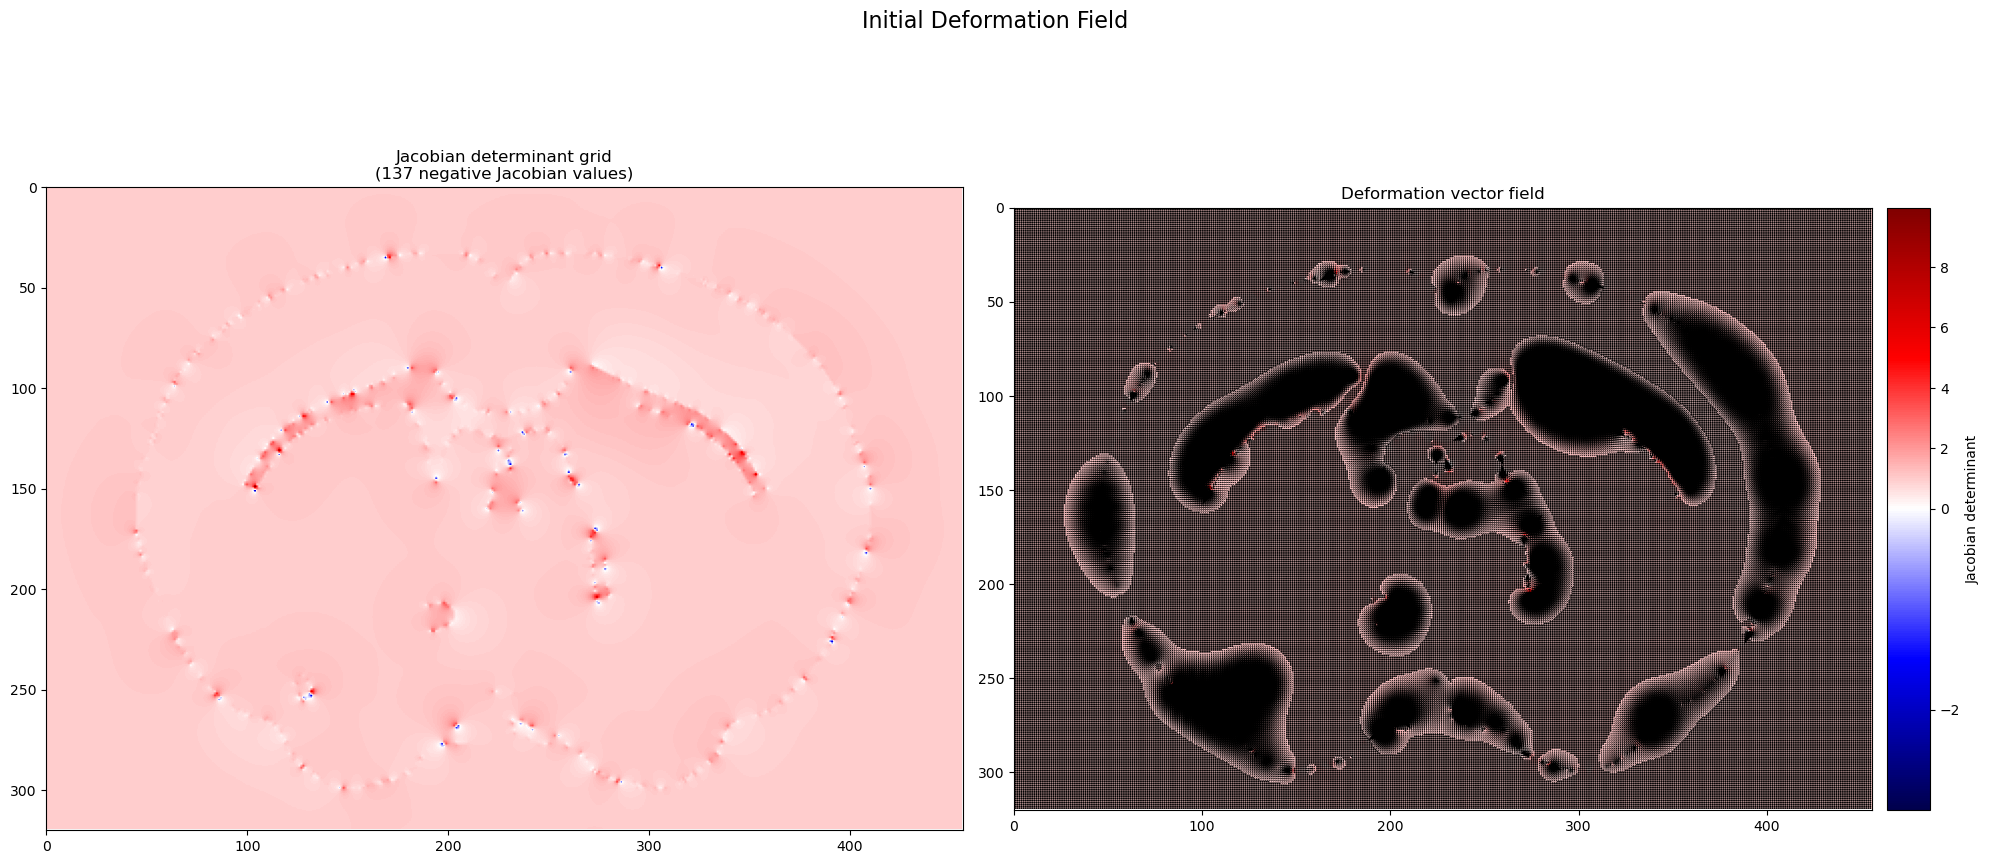

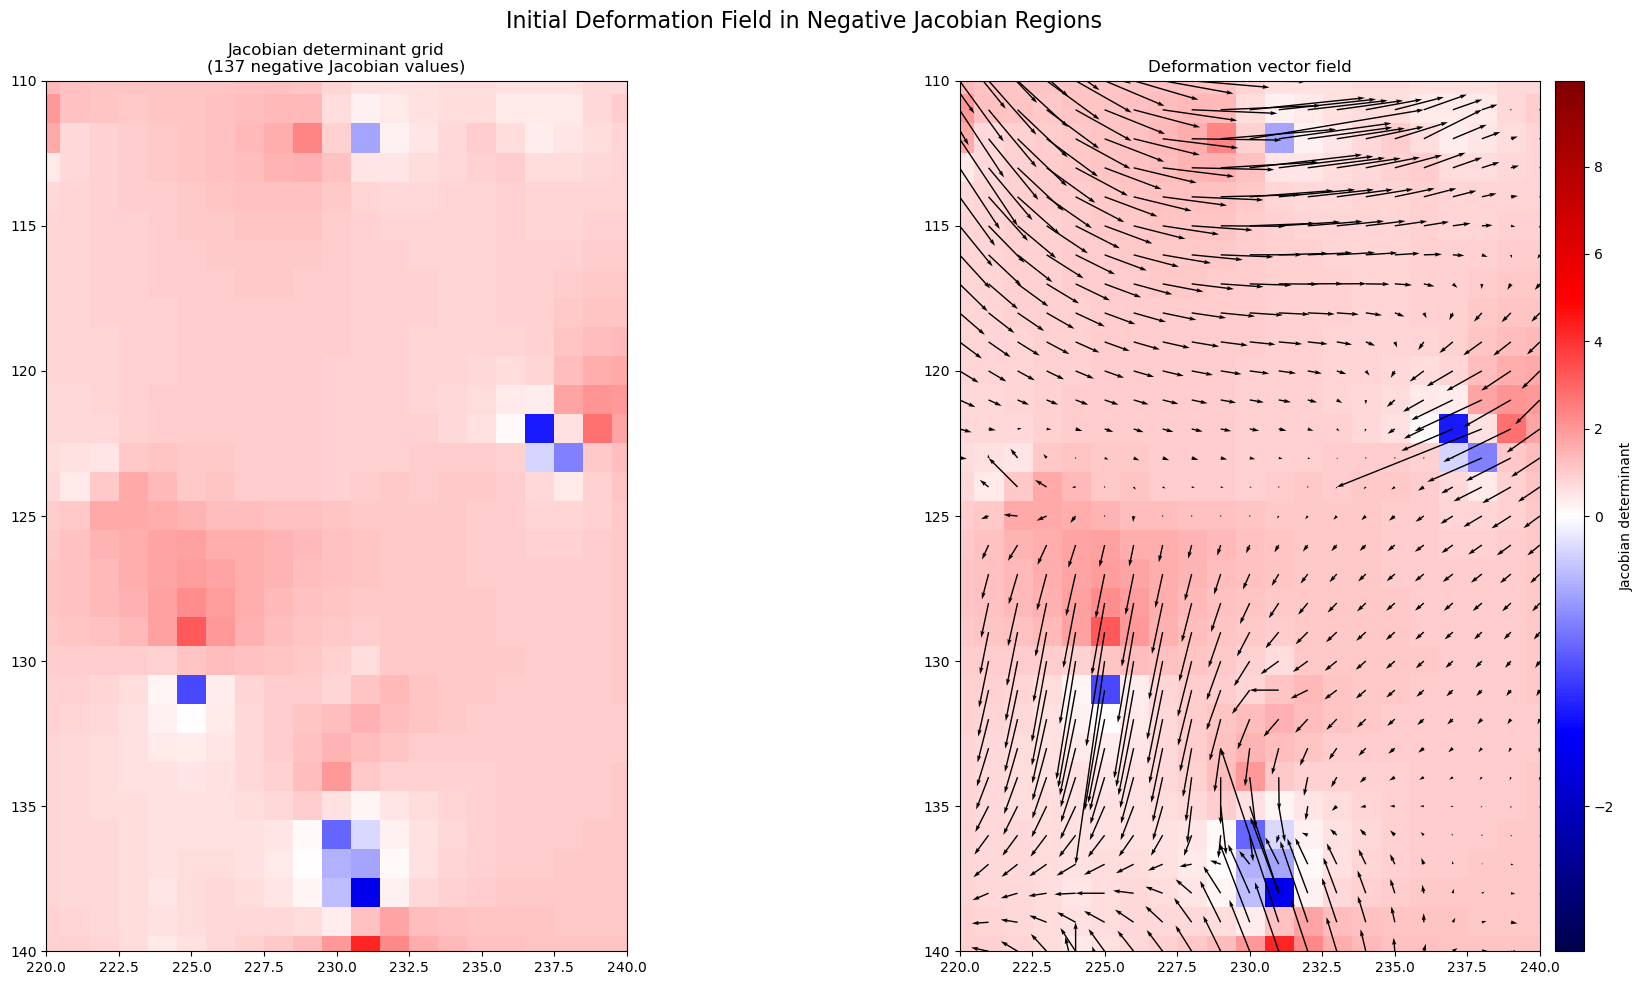

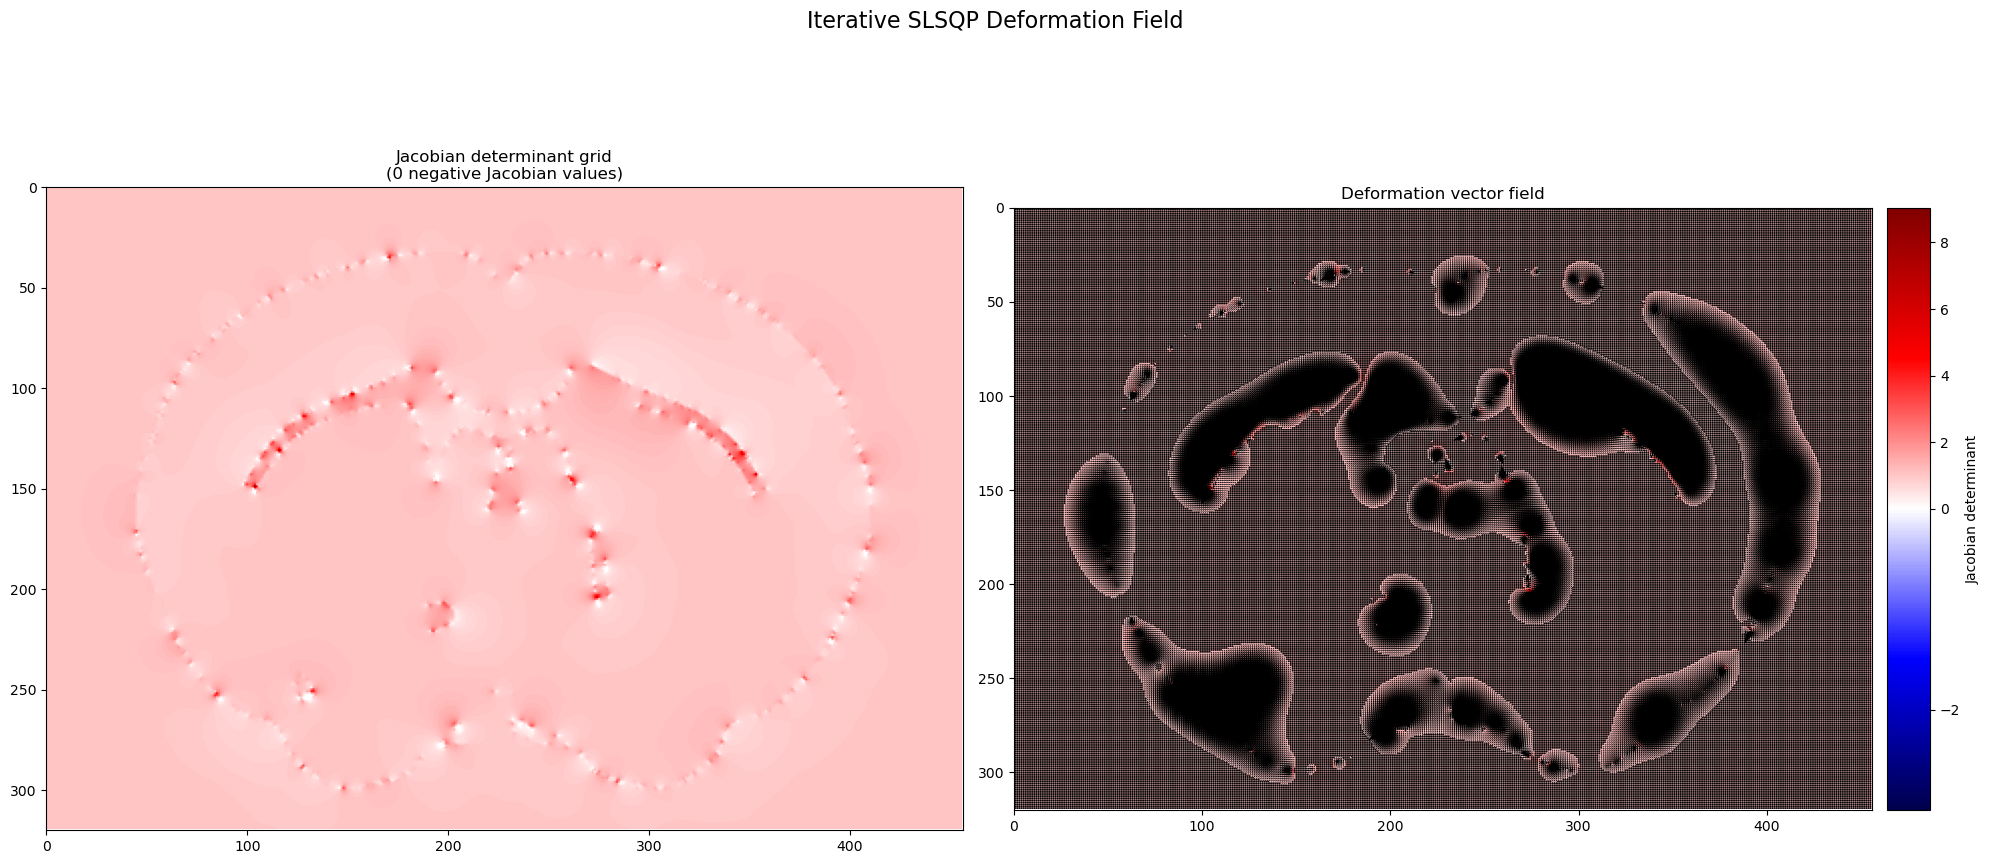

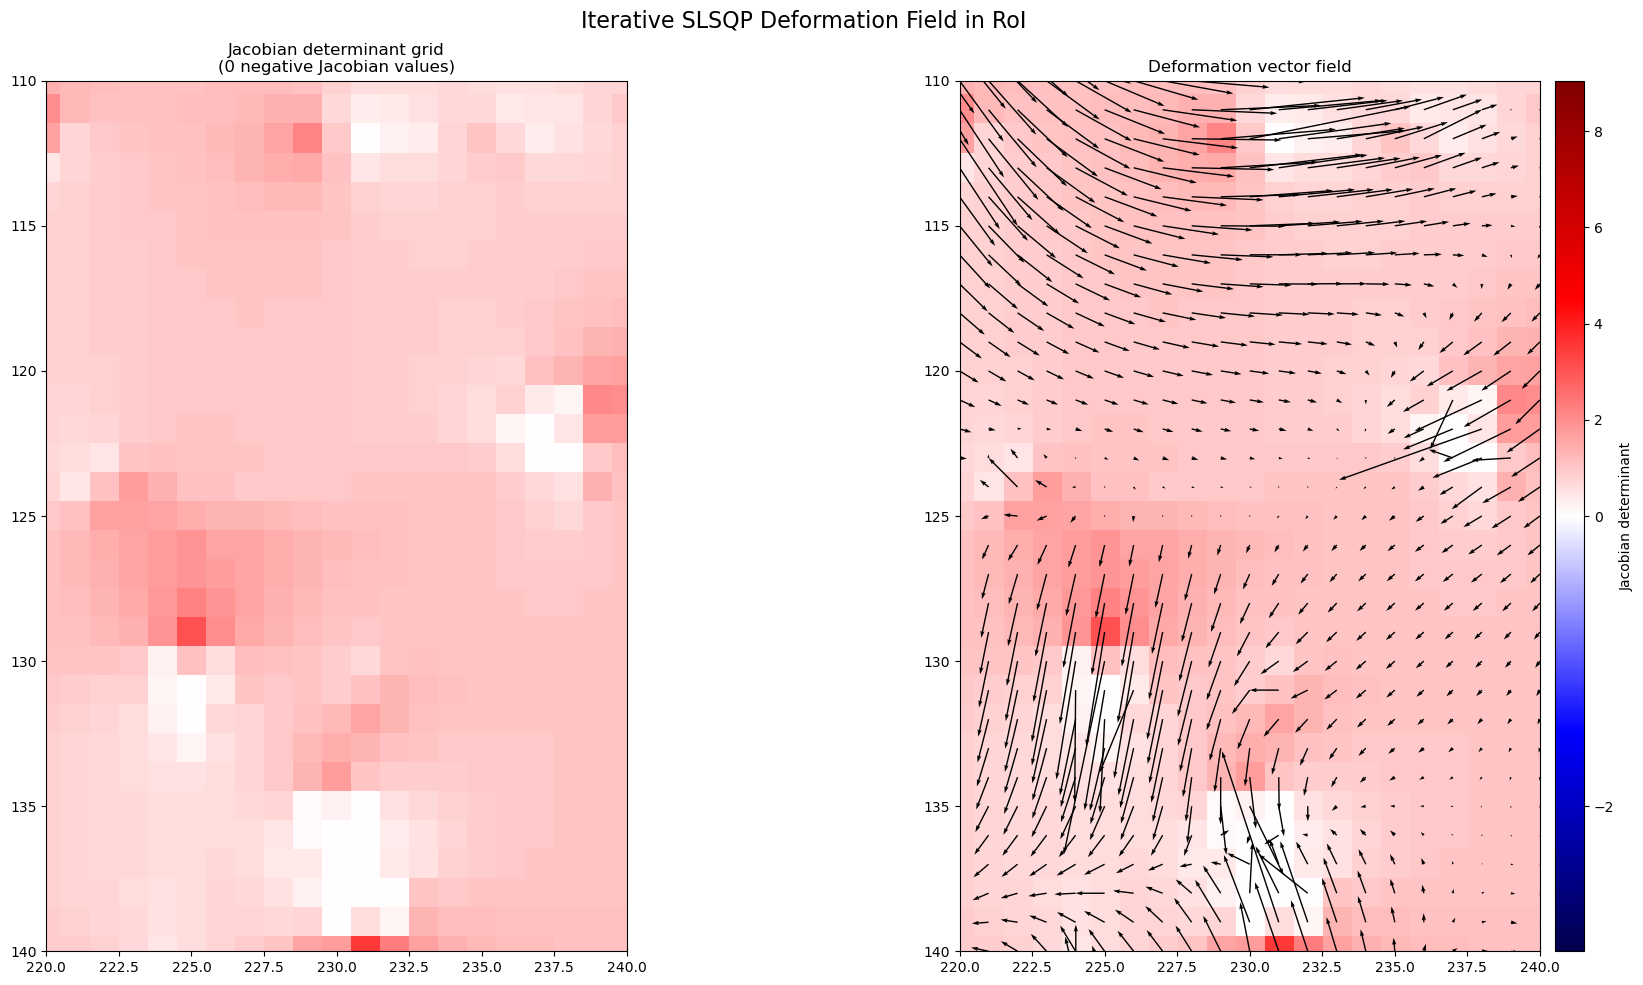

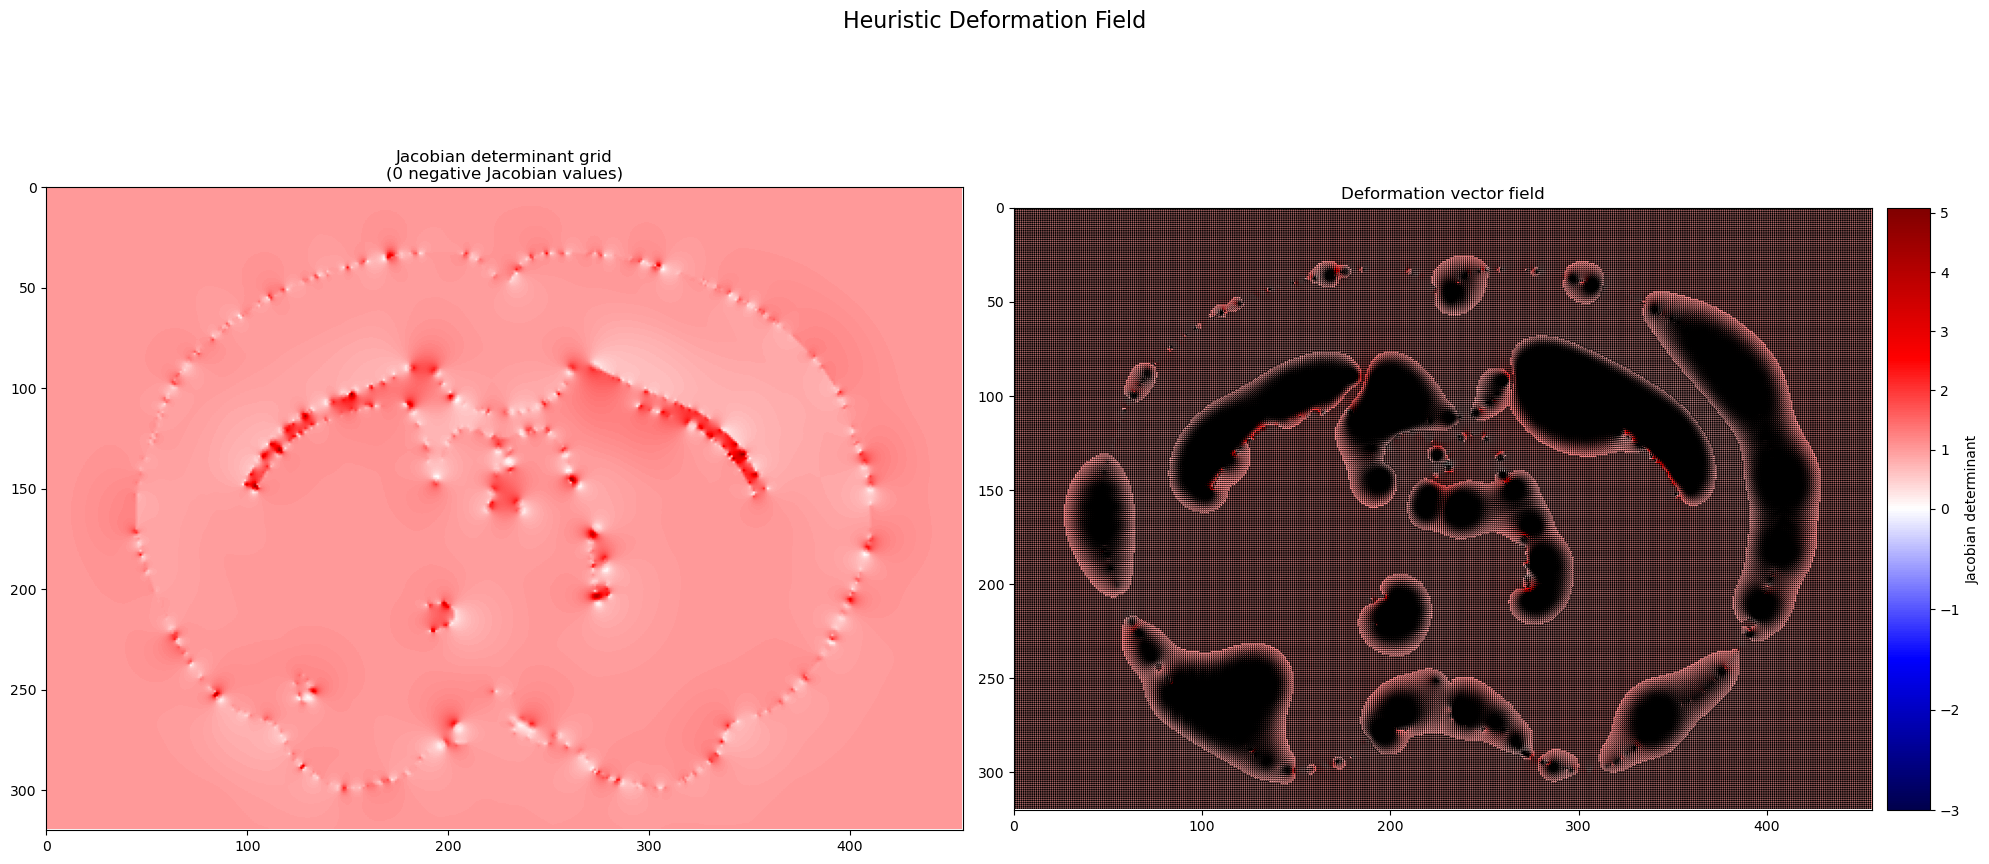

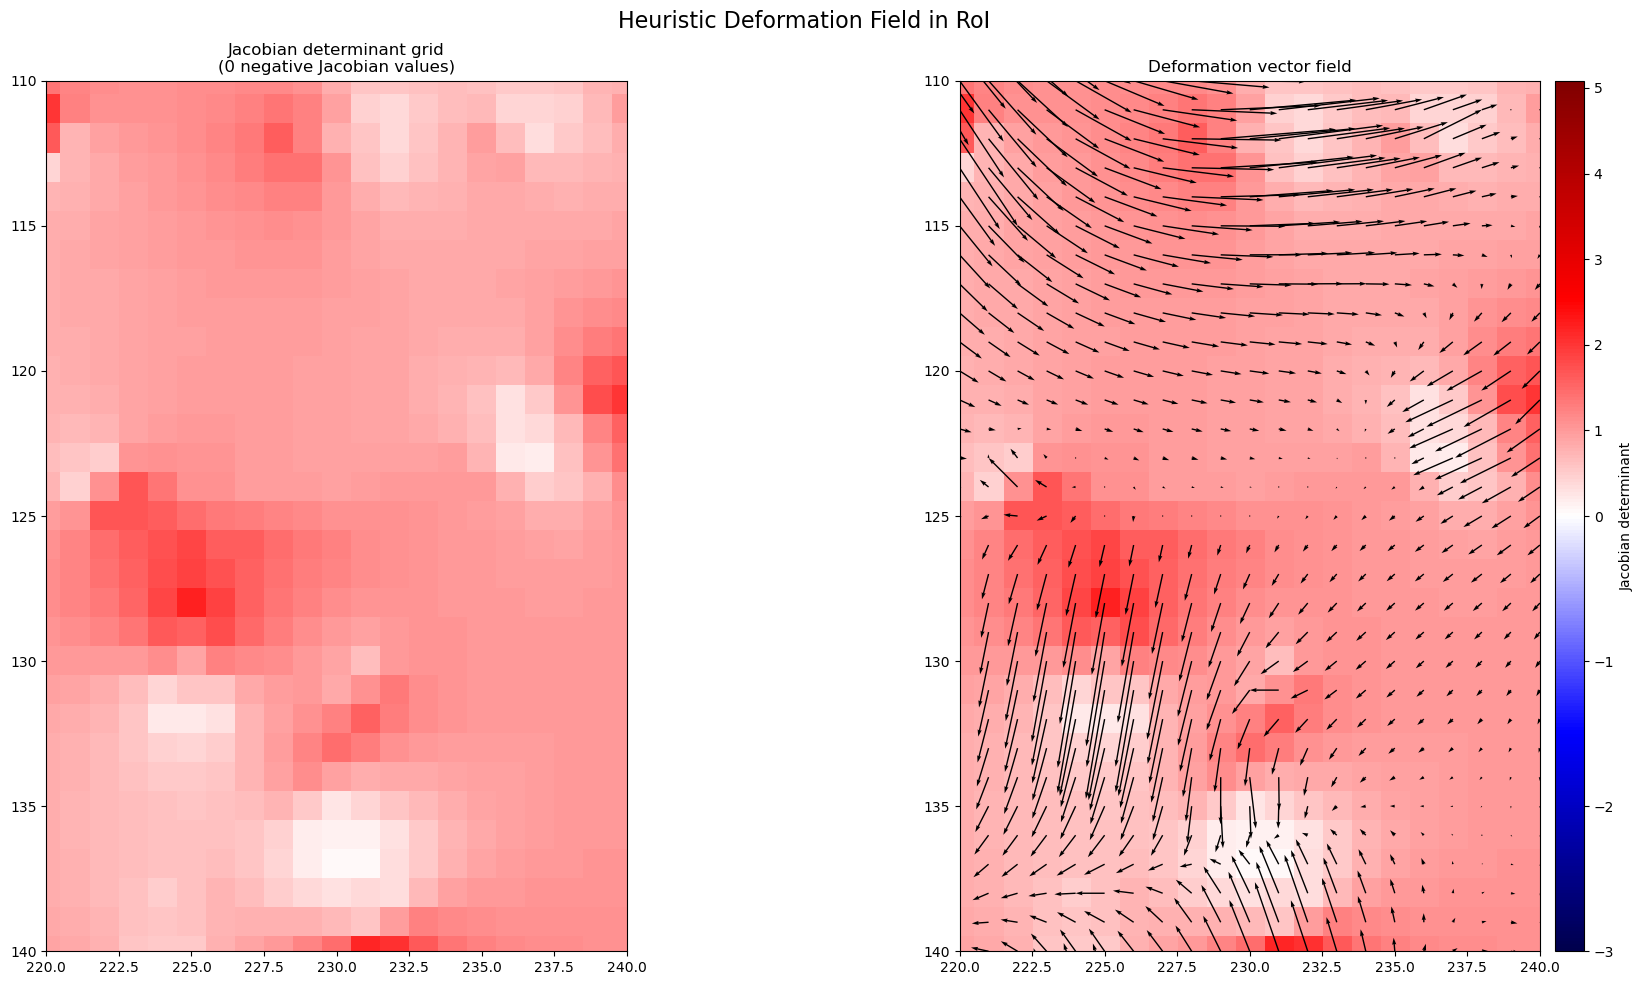

In [34]:
deformation_path = "experiments/02b_320x456_slice200.npy"
#deformation_full_slsqp_path = "paper_outputs/experiments/full_slsqp/02b_320x456_slice200_full_slsqp.npy"
deformation_iter_slsqp_path = "paper_outputs/experiments/iterative_slsqp/full_resolution/real_data_slice200_full/phi.npy"
deformation_heuristic_path = "paper_outputs/experiments/heuristic/full_resolution/real_data_slice200_full/phi.npy"

xlim = (220, 240)
ylim = (110, 140)

#xlim = (227, 232)
#ylim = (130, 140)

# Load the deformation field
deformation = np.load(deformation_path)
deformation_iter_slsqp = np.load(deformation_iter_slsqp_path)
deformation_heuristic = np.load(deformation_heuristic_path)

print(f"Deformation shape: {deformation_iter_slsqp.shape}")

# Process iterative SLSQP deformation
zeros = np.zeros((1, deformation_iter_slsqp.shape[1], deformation_iter_slsqp.shape[2]))
deformation_iter_slsqp = np.concatenate([zeros, deformation_iter_slsqp], axis=0)
deformation_iter_slsqp = deformation_iter_slsqp[:, np.newaxis, :, :]

print(f"Deformation shape: {deformation.shape}")
print(f"Iterative SLSQP deformation shape: {deformation_iter_slsqp.shape}")
print(f"Heuristic deformation shape: {deformation_heuristic.shape}")

# Show the deformation field
plot_deformation(deformation, title="Initial Deformation Field", show_values=False, quiver_scale=1)
plot_deformation(deformation, title="Initial Deformation Field in Negative Jacobian Regions", show_values=False, xlim=xlim, ylim=ylim, quiver_scale=1)
plot_deformation(deformation_iter_slsqp, title="Iterative SLSQP Deformation Field", show_values=False, quiver_scale=1)
plot_deformation(deformation_iter_slsqp, title="Iterative SLSQP Deformation Field in RoI", show_values=False, xlim=xlim, ylim=ylim, quiver_scale=1)
plot_deformation(deformation_heuristic, title="Heuristic Deformation Field", show_values=False, quiver_scale=1)
plot_deformation(deformation_heuristic, title="Heuristic Deformation Field in RoI", show_values=False, xlim=xlim, ylim=ylim, quiver_scale=1)

Image shape:  (1, 320, 456)


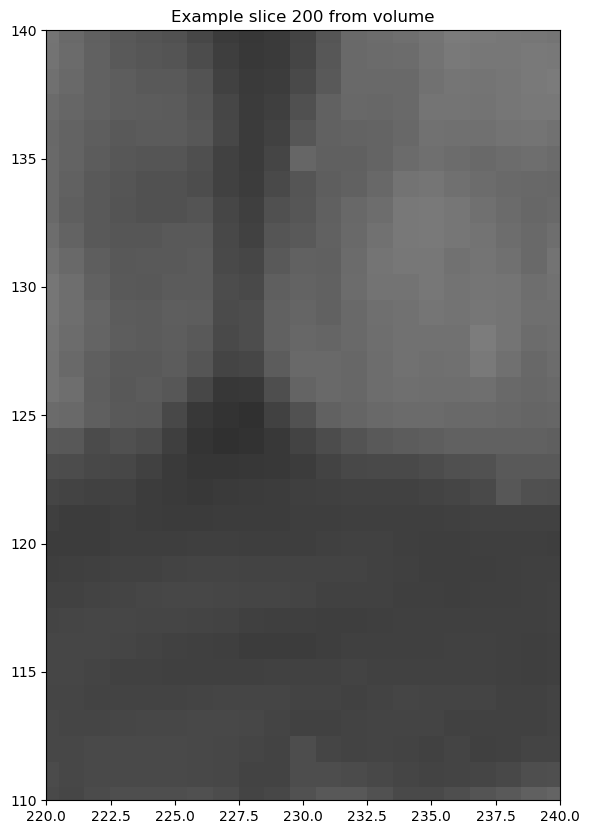

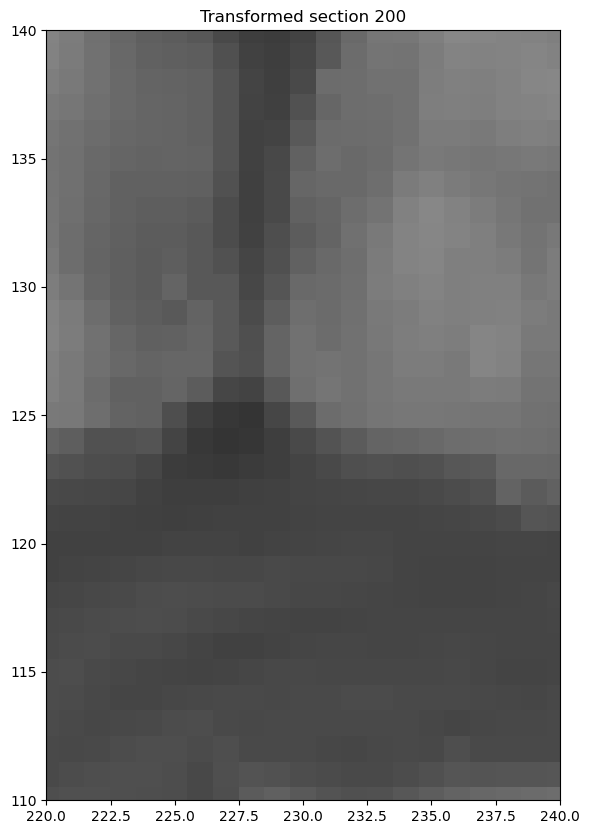

In [29]:
# Next, let's load in the image volume.
volume_path = "data/base_unique_correspondences/registered_output/elastixRefined.nii.gz"

volume = nib.load(volume_path).get_fdata()
image = volume[200]
image = np.expand_dims(image, axis=0) # Add a new axis to make it 3D
print("Image shape: ", image.shape)

# Let's plot an example slice from the volume
plt.figure(figsize=(10, 10))
plt.imshow(image[0], cmap="gray")
plt.title("Example slice 200 from volume")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

transformedData = geometric_transform(image, partial(shift3Dfunc, 
                                                      dx=deformation[0], 
                                                      dy=deformation[1], 
                                                      dz=deformation[2]))

plt.figure(figsize=(10, 10))
plt.imshow(transformedData[0, :, :], cmap="gray")
plt.title("Transformed section 200")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

### Do it with checkerboards

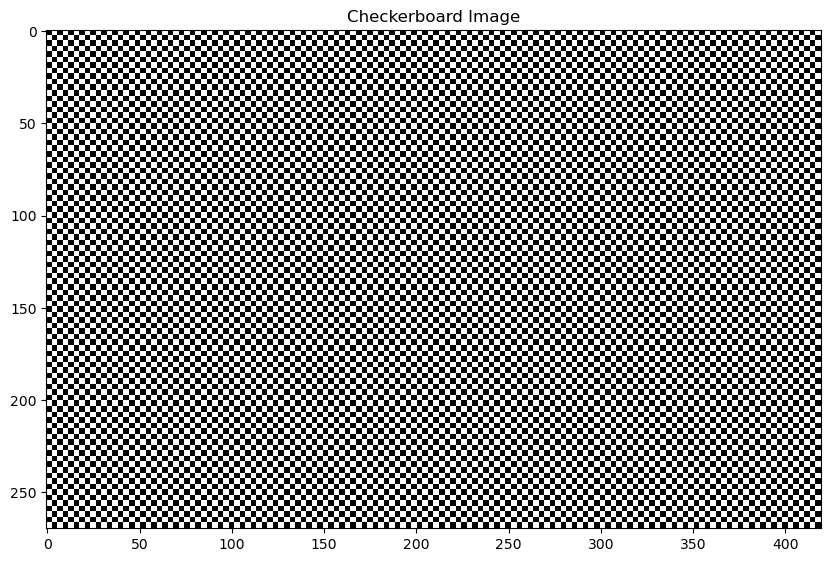

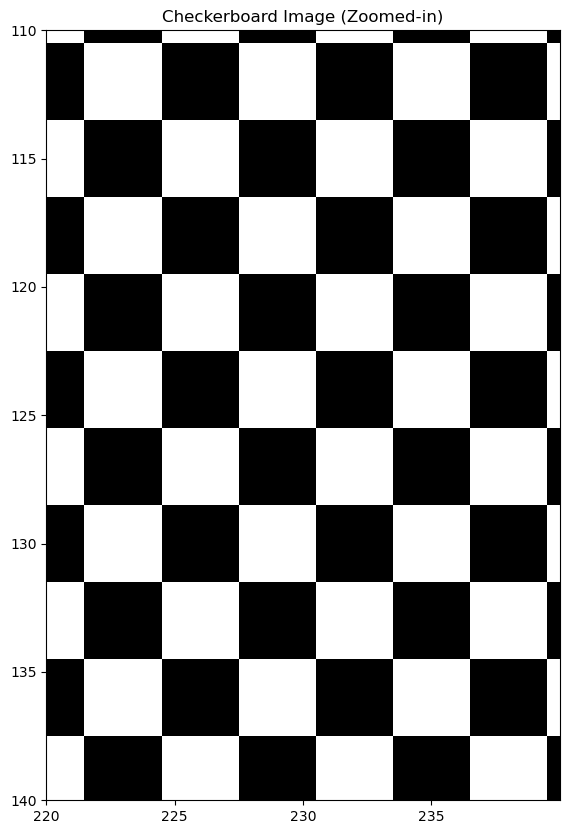

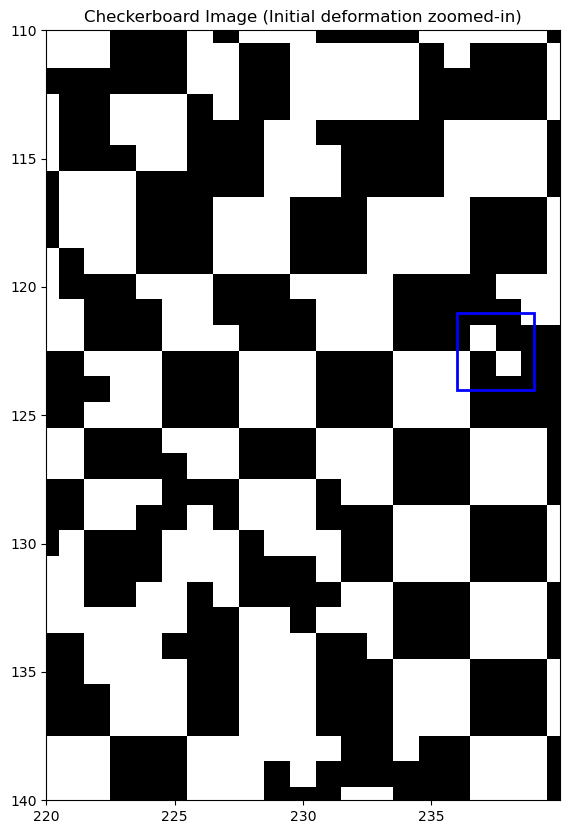

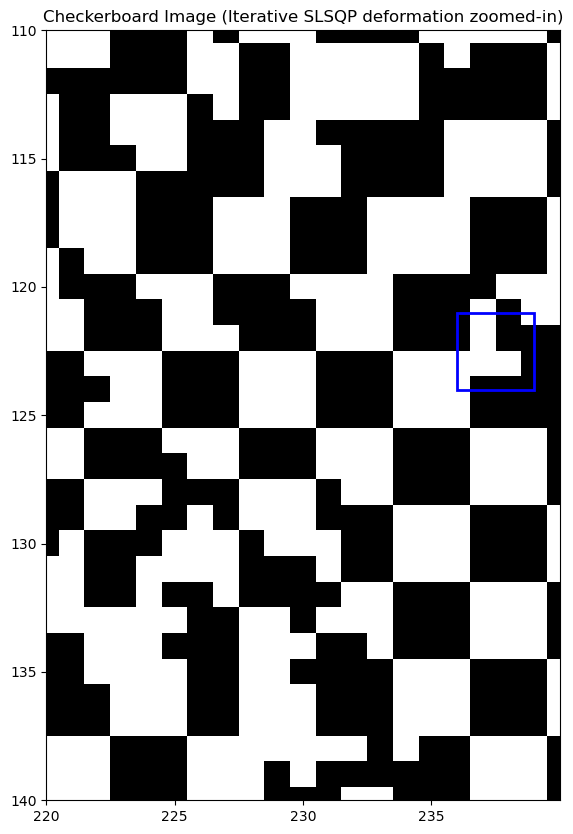

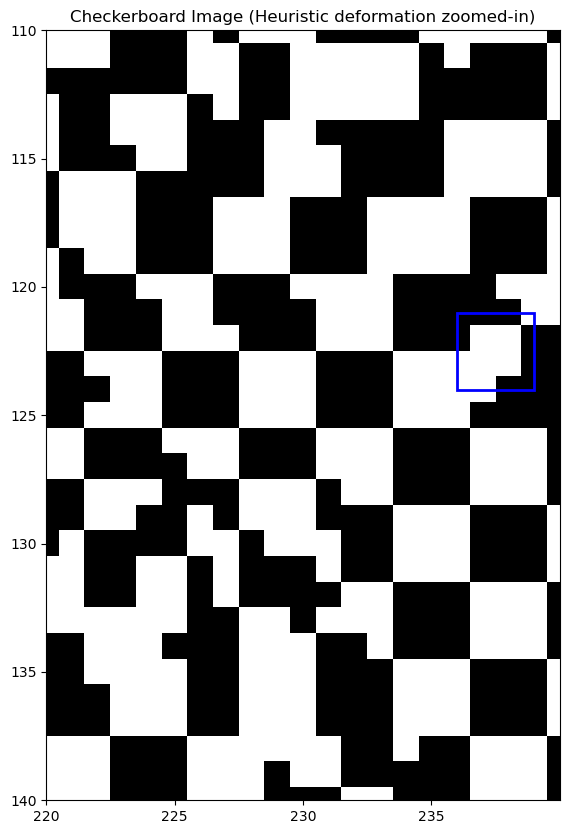

In [53]:
# Example usage
num_squares = (90, 140)  # Number of squares in the checkerboard (64, 90) default, 190/140 is also good

checkerboard_img = create_checkerboard(num_squares=num_squares, final_resolution=(320, 456))

checkerboard_img = np.expand_dims(checkerboard_img, axis=0) # Add a new axis to make it 3D

# 122, 237
neg_jacobian_at = (122, 237)
box_size = 3


transformed_checkerboard = geometric_transform(checkerboard_img, partial(shift3Dfunc, 
                                                                         dx=deformation[0], 
                                                                         dy=deformation[1], 
                                                                         dz=deformation[2]))

transformed_checkerboard_iterative = geometric_transform(checkerboard_img, partial(shift3Dfunc, 
                                                                         dx=deformation_iter_slsqp[0], 
                                                                         dy=deformation_iter_slsqp[1], 
                                                                         dz=deformation_iter_slsqp[2]))


transformed_checkerboard_heuristic = geometric_transform(checkerboard_img, partial(shift3Dfunc, 
                                                                         dx=deformation_heuristic[0], 
                                                                         dy=deformation_heuristic[1], 
                                                                         dz=deformation_heuristic[2]))

# Threshold the transformed checkerboard to create a binary image
transformed_checkerboard = np.where(transformed_checkerboard > 0.5, 1, 0)
transformed_checkerboard_iterative = np.where(transformed_checkerboard_iterative > 0.5, 1, 0)
transformed_checkerboard_heuristic = np.where(transformed_checkerboard_heuristic > 0.5, 1, 0)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(checkerboard_img[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image')
plt.show()

# Display the image (zoomed-in)
plt.figure(figsize=(10, 10))
plt.imshow(checkerboard_img[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
# Inbert y-axis to match the original image orientation
plt.gca().invert_yaxis()
plt.show()

# Display the image (zoomed-in transformed checkerboard)
plt.figure(figsize=(10, 10))
plt.imshow(transformed_checkerboard[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Initial deformation zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
plt.gca().invert_yaxis()
# Add a blue rectangle
rect = patches.Rectangle((neg_jacobian_at[1] - box_size // 2, neg_jacobian_at[0] - box_size // 2), box_size, box_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

# Display the image (zoomed-in transformed checkerboard)
plt.figure(figsize=(10, 10))
plt.imshow(transformed_checkerboard_iterative[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Iterative SLSQP deformation zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
plt.gca().invert_yaxis()
# Add a blue rectangle
rect = patches.Rectangle((neg_jacobian_at[1] - box_size // 2, neg_jacobian_at[0] - box_size // 2), box_size, box_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

# Display the image (zoomed-in transformed checkerboard)
plt.figure(figsize=(10, 10))
plt.imshow(transformed_checkerboard_heuristic[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Heuristic deformation zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
plt.gca().invert_yaxis()
# Add a blue rectangle
rect = patches.Rectangle((neg_jacobian_at[1] - box_size // 2, neg_jacobian_at[0] - box_size // 2), box_size, box_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

## 2nd try

In [ ]:
# Example usage
num_squares = (90, 140)  # Number of squares in the checkerboard (64, 90) default, 190/140 is also good

checkerboard_img = create_checkerboard(num_squares=num_squares, final_resolution=(320, 456))

checkerboard_img = np.expand_dims(checkerboard_img, axis=0) # Add a new axis to make it 3D

# 122, 237
neg_jacobian_at = (122, 237)
box_size = 3


transformed_checkerboard = geometric_transform(checkerboard_img, partial(shift3Dfunc, 
                                                                         dx=deformation[0], 
                                                                         dy=deformation[1], 
                                                                         dz=deformation[2]))

transformed_checkerboard_iterative = geometric_transform(checkerboard_img, partial(shift3Dfunc, 
                                                                         dx=deformation_iter_slsqp[0], 
                                                                         dy=deformation_iter_slsqp[1], 
                                                                         dz=deformation_iter_slsqp[2]))


transformed_checkerboard_heuristic = geometric_transform(checkerboard_img, partial(shift3Dfunc, 
                                                                         dx=deformation_heuristic[0], 
                                                                         dy=deformation_heuristic[1], 
                                                                         dz=deformation_heuristic[2]))

# Threshold the transformed checkerboard to create a binary image
transformed_checkerboard = np.where(transformed_checkerboard > 0.5, 1, 0)
transformed_checkerboard_iterative = np.where(transformed_checkerboard_iterative > 0.5, 1, 0)
transformed_checkerboard_heuristic = np.where(transformed_checkerboard_heuristic > 0.5, 1, 0)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(checkerboard_img[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image')
plt.show()

# Display the image (zoomed-in)
plt.figure(figsize=(10, 10))
plt.imshow(checkerboard_img[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
# Inbert y-axis to match the original image orientation
plt.gca().invert_yaxis()
plt.show()

# Display the image (zoomed-in transformed checkerboard)
plt.figure(figsize=(10, 10))
plt.imshow(transformed_checkerboard[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Initial deformation zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
plt.gca().invert_yaxis()
# Add a blue rectangle
rect = patches.Rectangle((neg_jacobian_at[1] - box_size // 2, neg_jacobian_at[0] - box_size // 2), box_size, box_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

# Display the image (zoomed-in transformed checkerboard)
plt.figure(figsize=(10, 10))
plt.imshow(transformed_checkerboard_iterative[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Iterative SLSQP deformation zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
plt.gca().invert_yaxis()
# Add a blue rectangle
rect = patches.Rectangle((neg_jacobian_at[1] - box_size // 2, neg_jacobian_at[0] - box_size // 2), box_size, box_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

# Display the image (zoomed-in transformed checkerboard)
plt.figure(figsize=(10, 10))
plt.imshow(transformed_checkerboard_heuristic[0], cmap='gray', interpolation='nearest')
plt.title('Checkerboard Image (Heuristic deformation zoomed-in)')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(np.arange(*plt.xlim(), 5))  # <-- Add this line
plt.gca().invert_yaxis()
# Add a blue rectangle
rect = patches.Rectangle((neg_jacobian_at[1] - box_size // 2, neg_jacobian_at[0] - box_size // 2), box_size, box_size,
                        linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

In [ ]:
transformedData = geometric_transform(volume, partial(shift3Dfunc, 
                                                      dx=deformation_field[0], 
                                                      dy=deformation_field[1], 
                                                      dz=deformation_field[2]))

plt.figure(figsize=(10, 10))
plt.imshow(transformedData[200, :, :], cmap="gray")
plt.title("Transformed section 200")
plt.show()